In [1]:
import pandas as pd
from datetime import datetime as dt

In [2]:
#!pip install --upgrade seaborn matplotlib pandas --user

In [3]:
us_wildfires = pd.read_csv('us_wildfires_filled.csv')

In [4]:
us_wildfires['DISCOVERY_DATE'] = pd.to_datetime(us_wildfires["DISCOVERY_DATE"], format = "%Y-%m-%d")
us_wildfires['CONT_DATE'] = pd.to_datetime(us_wildfires["CONT_DATE"], format = "%Y-%m-%d")

In [5]:
us_wildfires.isna().sum()

OBJECTID                     0
NWCG_REPORTING_AGENCY        0
NWCG_REPORTING_UNIT_ID       0
FIRE_NAME                    0
FIRE_YEAR                    0
DISCOVERY_DATE               0
NWCG_CAUSE_CLASSIFICATION    0
NWCG_GENERAL_CAUSE           0
NWCG_CAUSE_AGE_CATEGORY      0
CONT_DATE                    0
FIRE_SIZE                    0
FIRE_SIZE_CLASS              0
LATITUDE                     0
LONGITUDE                    0
OWNER_DESCR                  0
DURATION                     0
COUNTY                       0
STATE                        0
PRECIPITATION                0
TEMPERATURE                  0
WIND_SPEED                   0
ELEVATION                    0
dtype: int64

In [6]:
to_drop = ['OBJECTID', 'LATITUDE', 'LONGITUDE', 'FIRE_NAME']
model_data = us_wildfires.drop(to_drop, axis=1)

In [7]:
model_data['DAY_OF_WEEK'] = model_data['DISCOVERY_DATE'].dt.dayofweek

In [8]:
model_data['DAY_OF_YEAR'] = model_data['DISCOVERY_DATE'].dt.dayofyear

In [9]:
date_drop = ['DISCOVERY_DATE', 'CONT_DATE']
model_data = model_data.drop(model_data[date_drop], axis=1)

In [10]:
more_drops = ['NWCG_REPORTING_UNIT_ID', 'FIRE_SIZE_CLASS',
             'NWCG_CAUSE_CLASSIFICATION', 'NWCG_CAUSE_AGE_CATEGORY']
model_data = model_data.drop(more_drops, axis=1)

In [11]:
model_data['COUNTY_STATE'] = model_data['COUNTY'] + str(" ") + model_data['STATE']

In [12]:
model_data[['COUNTY_STATE', 'COUNTY', 'STATE']].head()

,COUNTY_STATE,COUNTY,STATE
0,Plumas County CA,Plumas County,CA
1,El Dorado County CA,El Dorado County,CA
2,Placer County CA,Placer County,CA
3,Alpine County CA,Alpine County,CA
4,Alpine County CA,Alpine County,CA


In [13]:
model_data = model_data.drop('COUNTY', axis=1)

In [14]:
model_data.columns.to_list()

['NWCG_REPORTING_AGENCY',
 'FIRE_YEAR',
 'NWCG_GENERAL_CAUSE',
 'FIRE_SIZE',
 'OWNER_DESCR',
 'DURATION',
 'STATE',
 'PRECIPITATION',
 'TEMPERATURE',
 'WIND_SPEED',
 'ELEVATION',
 'DAY_OF_WEEK',
 'DAY_OF_YEAR',
 'COUNTY_STATE']

In [15]:
model_data['COUNTY_STATE'] = model_data['COUNTY_STATE'].astype('category')
model_data['COUNTY_STATE'] = model_data['COUNTY_STATE'].cat.codes.astype(int)

In [16]:
model_data['STATE'] = model_data['STATE'].astype('category')
model_data['STATE'] = model_data['STATE'].cat.codes.astype(int)

In [17]:
model_data['NWCG_REPORTING_AGENCY'] = model_data['NWCG_REPORTING_AGENCY'].astype('category')
model_data['NWCG_REPORTING_AGENCY'] = model_data['NWCG_REPORTING_AGENCY'].cat.codes.astype(int)

In [18]:
model_data['OWNER_DESCR'] = model_data['OWNER_DESCR'].astype('category')
model_data['OWNER_DESCR'] = model_data['OWNER_DESCR'].cat.codes.astype(int)

# Running a random forest again

Using all data as usual, combining 'other' with 'undetermined', have dropped cause_age and cause_category

In [19]:
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
#from imblearn.under_sampling import RandomUnderSampler
import time

In [20]:
model_data['NWCG_GENERAL_CAUSE'] = model_data['NWCG_GENERAL_CAUSE'].replace({'Other causes': 'Undetermined',
                                                                             'Undetermined': 'Undetermined'})

In [21]:
X1 = model_data.drop("NWCG_GENERAL_CAUSE", axis=1)
y1 = model_data["NWCG_GENERAL_CAUSE"]


X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2, shuffle=True, random_state=2)

In [22]:
dt1 = DecisionTreeClassifier()
dt1.fit(X1_train,y1_train)
dt1_predictions = dt1.predict(X1_test)
dt1_acc = accuracy_score(y1_test, dt1_predictions)
print(f"Decision Tree Accuracy Score: {dt1_acc}")

Decision Tree Accuracy Score: 0.47407636364717104


In [23]:
start_time = time.time()

rf1 = RandomForestClassifier()
rf1.fit(X1_train, y1_train)
rf1_predictions = rf1.predict(X1_test)
rf1_acc = accuracy_score(y1_test, rf1_predictions)
print(f"Random Forest Accuracy Score: {rf1_acc}")

print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5787457388347812
--- 418.72 seconds ---


In [24]:
report = classification_report(y1_test, rf1_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [25]:
report_df

,precision,recall,f1-score,support
Arson,0.540327,0.467944,0.501537,43751.000000
Debris and open burning,0.540262,0.706448,0.612279,81638.000000
Equipment and vehicle use,0.416144,0.248025,0.310807,28352.000000
Firearms and explosives use,0.797571,0.388560,0.522546,507.000000
Fireworks,0.597222,0.382916,0.466640,3032.000000
Misuse of fire by a minor,0.303176,0.110436,0.161898,8557.000000
Natural,0.752306,0.814556,0.782194,46359.000000
Power supply,0.372233,0.093608,0.149596,5929.000000
Railroad operations and maintenance,0.584020,0.372570,0.454925,3806.000000
Recreation and ceremony,0.502488,0.338346,0.404396,14030.000000


In [26]:
feature_importances = pd.DataFrame(
    rf1.feature_importances_, 
    index =X1_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances

,importance
TEMPERATURE,0.115568
DAY_OF_YEAR,0.113573
ELEVATION,0.110516
WIND_SPEED,0.106069
FIRE_SIZE,0.093405
FIRE_YEAR,0.082485
COUNTY_STATE,0.079173
PRECIPITATION,0.078651
STATE,0.077066
DAY_OF_WEEK,0.055127


# Random Forest Dataset 2

data with OWNER_DESCR and NWCG_REPORTING_AGENCY removed

In [27]:
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)

In [28]:
X2 = data_2.drop("NWCG_GENERAL_CAUSE", axis=1)
y2 = data_2["NWCG_GENERAL_CAUSE"]


X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.2, shuffle=True, random_state=2)

In [29]:
dt2 = DecisionTreeClassifier()
dt2.fit(X2_train,y2_train)
dt2_predictions = dt2.predict(X2_test)
dt2_acc = accuracy_score(y2_test, dt2_predictions)
print(f"Decision Tree Accuracy Score: {dt2_acc}")

Decision Tree Accuracy Score: 0.45790251107828656


In [30]:
start_time = time.time()

rf2 = RandomForestClassifier()
rf2.fit(X2_train, y2_train)
rf2_predictions = rf2.predict(X2_test)
rf2_acc = accuracy_score(y2_test, rf2_predictions)
rf2_f1 = f1_score(y2_test, rf2_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf2_acc}, F1-Score: {rf2_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5578760599044785, F1-Score: 0.5353198222516354
--- 446.72 seconds ---


In [31]:
from sklearn.metrics import f1_score

In [32]:

rf2_f1 = f1_score(y2_test, rf2_predictions, average='micro')

In [33]:
rf2_f1

0.5578760599044785

In [34]:
report = classification_report(y2_test, rf2_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Arson,0.518375,0.447807,0.480514,43751.000000
Debris and open burning,0.524740,0.686029,0.594641,81638.000000
Equipment and vehicle use,0.381503,0.218821,0.278119,28352.000000
Firearms and explosives use,0.731707,0.355030,0.478088,507.000000
Fireworks,0.578390,0.360158,0.443902,3032.000000
Misuse of fire by a minor,0.277120,0.098516,0.145357,8557.000000
Natural,0.730706,0.807136,0.767022,46359.000000
Power supply,0.338217,0.089560,0.141619,5929.000000
Railroad operations and maintenance,0.563456,0.358119,0.437912,3806.000000
Recreation and ceremony,0.431868,0.253457,0.319439,14030.000000


In [35]:
feature_importances2 = pd.DataFrame(
    rf2.feature_importances_, 
    index =X2_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances2

,importance
ELEVATION,0.126458
TEMPERATURE,0.122443
DAY_OF_YEAR,0.122382
WIND_SPEED,0.113503
FIRE_SIZE,0.100347
FIRE_YEAR,0.085323
COUNTY_STATE,0.084705
STATE,0.082501
PRECIPITATION,0.081010
DAY_OF_WEEK,0.057905


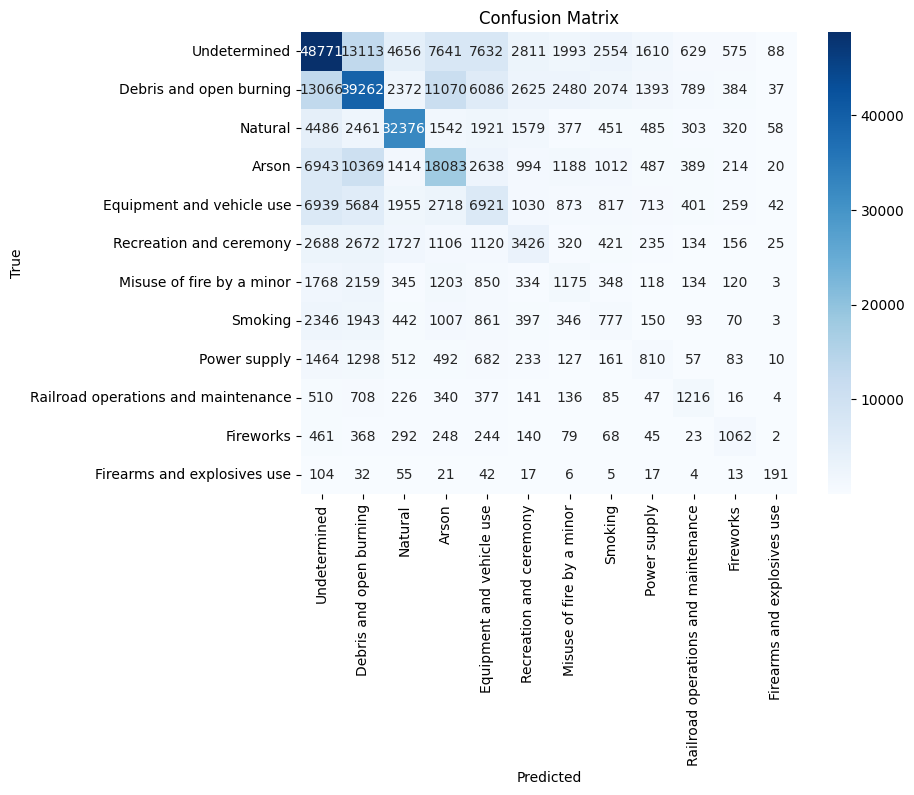

In [36]:
# Make a correlation matrix 
labels = y2_test.value_counts().index
cm = confusion_matrix(y2_test, dt2_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Creating dataset 2 - removing undetermined and combining other categories
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_3 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']

# Combining Railroad, Power & Equipment/Vehicle
# data_3['NWCG_GENERAL_CAUSE'] = data_3['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
#                                                                           'Power supply': 'Infrastructure-related causes',
#                                                                           'Equipment and vehicle use': 'Infrastructure-related causes'})

# I am going to drop 'firearms & explosives use' as they don't fit exactly
# into another category, and there's so relatively few of them
# data_2 = data_2[data_2['NWCG_GENERAL_CAUSE']!='Firearms and explosives use']

# Combining FIreworks with Recreation & Ceremony
# data_2['NWCG_GENERAL_CAUSE'] = data_2['NWCG_GENERAL_CAUSE'].replace({'Fireworks': 'Recreation and ceremony'})


In [38]:
X3 = data_3.drop("NWCG_GENERAL_CAUSE", axis=1)
y3 = data_3["NWCG_GENERAL_CAUSE"]


X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3, test_size=0.2, shuffle=True, random_state=2)

In [39]:
dt3 = DecisionTreeClassifier()
dt3.fit(X3_train,y3_train)
dt3_predictions = dt3.predict(X3_test)
dt3_acc = accuracy_score(y3_test, dt3_predictions)
dt3_f1 = f1_score(y3_test, dt3_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt3_acc}, f1 Score: {dt3_f1}")

Decision Tree Accuracy Score: 0.4858623302680894, f1 Score: 0.4858623302680894


In [40]:
start_time = time.time()

rf3 = RandomForestClassifier()
rf3.fit(X3_train, y3_train)
rf3_predictions = rf3.predict(X3_test)
rf3_acc = accuracy_score(y3_test, rf3_predictions)
rf3_f1 = f1_score(y3_test, rf3_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf3_acc}, F1-Score: {rf3_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5939050115714666, F1-Score: 0.568513143408119
--- 276.11 seconds ---


In [41]:
report3 = classification_report(y3_test, rf3_predictions, output_dict=True)
report3_df = pd.DataFrame(report3).transpose()
report3_df

,precision,recall,f1-score,support
Arson,0.550363,0.518858,0.534146,43987.000000
Debris and open burning,0.583100,0.781724,0.667959,81081.000000
Equipment and vehicle use,0.462831,0.358451,0.404008,28347.000000
Firearms and explosives use,0.761905,0.371308,0.499291,474.000000
Fireworks,0.630808,0.401866,0.490959,3108.000000
Misuse of fire by a minor,0.313443,0.111138,0.164093,8413.000000
Natural,0.764443,0.838566,0.799791,46533.000000
Power supply,0.412570,0.113353,0.177843,5849.000000
Railroad operations and maintenance,0.622658,0.353060,0.450613,3954.000000
Recreation and ceremony,0.483320,0.315306,0.381640,13923.000000


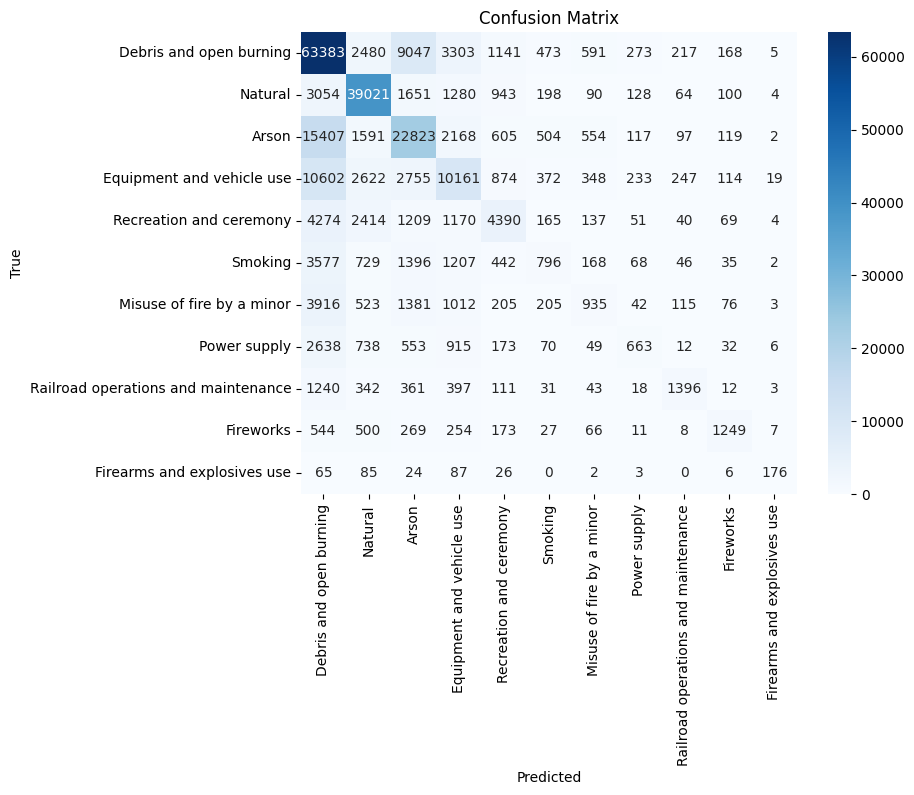

In [42]:
# Make a correlation matrix 
labels = y3_test.value_counts().index
cm = confusion_matrix(y3_test, rf3_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Creating dataset 4 - removing undetermined and combining other categories
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_4 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']

# Combining Railroad, Power & Equipment/Vehicle
data_4['NWCG_GENERAL_CAUSE'] = data_4['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
                                                                          'Power supply': 'Infrastructure-related causes',
                                                                          'Equipment and vehicle use': 'Infrastructure-related causes'})


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15012\2566683951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4['NWCG_GENERAL_CAUSE'] = data_4['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',


In [44]:
data_4['NWCG_GENERAL_CAUSE'].value_counts()

NWCG_GENERAL_CAUSE
Debris and open burning          405877
Natural                          231547
Arson                            219102
Infrastructure-related causes    190808
Recreation and ceremony           69984
Misuse of fire by a minor         43018
Smoking                           42540
Fireworks                         15376
Firearms and explosives use        2423
Name: count, dtype: int64

In [45]:
X4 = data_4.drop("NWCG_GENERAL_CAUSE", axis=1)
y4 = data_4["NWCG_GENERAL_CAUSE"]


X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4, test_size=0.2, shuffle=True, random_state=2)

In [46]:
dt4 = DecisionTreeClassifier()
dt4.fit(X4_train,y4_train)
dt4_predictions = dt4.predict(X4_test)
dt4_acc = accuracy_score(y4_test, dt4_predictions)
dt4_f1 = f1_score(y4_test, dt4_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt4_acc}, f1 Score: {dt4_f1}")

Decision Tree Accuracy Score: 0.4997972433284863, f1 Score: 0.4997972433284863


In [47]:
start_time = time.time()

rf4 = RandomForestClassifier()
rf4.fit(X4_train, y4_train)
rf4_predictions = rf4.predict(X4_test)
rf4_acc = accuracy_score(y4_test, rf4_predictions)
rf4_f1 = f1_score(y4_test, rf4_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf4_acc}, F1-Score: {rf4_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.602838593401192, F1-Score: 0.5823285009833832
--- 268.77 seconds ---


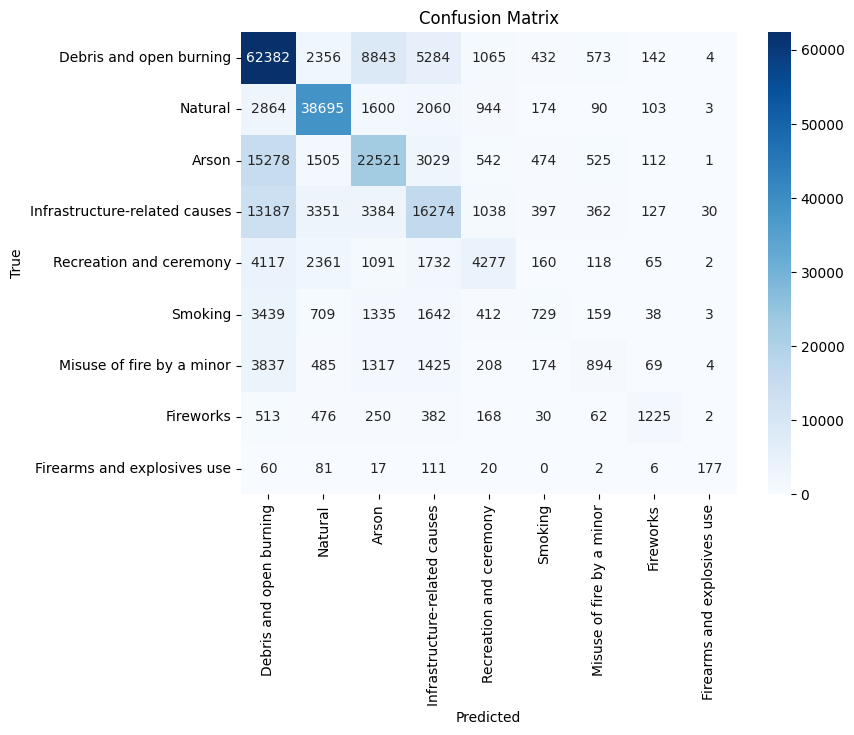

In [48]:
# Make a correlation matrix 
labels = y4_test.value_counts().index
cm = confusion_matrix(y4_test, rf4_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Dataset 5 - above but with 'eratic' category of minor & smoking

data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_5 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']


data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
                                                                          'Power supply': 'Infrastructure-related causes',
                                                                          'Equipment and vehicle use': 'Infrastructure-related causes'})
data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Smoking': 'Erratic',
                                                                     'Misuse of fire by a minor': 'Erratic'})


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15012\1900958897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15012\1900958897.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Smoking': 'Erratic',


In [50]:
data_5['NWCG_GENERAL_CAUSE'].value_counts()

NWCG_GENERAL_CAUSE
Debris and open burning          405877
Natural                          231547
Arson                            219102
Infrastructure-related causes    190808
Erratic                           85558
Recreation and ceremony           69984
Fireworks                         15376
Firearms and explosives use        2423
Name: count, dtype: int64

In [51]:
X5 = data_5.drop("NWCG_GENERAL_CAUSE", axis=1)
y5 = data_5["NWCG_GENERAL_CAUSE"]


X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5, test_size=0.2, shuffle=True, random_state=2)

In [ ]:
dt5 = DecisionTreeClassifier()
dt5.fit(X5_train,y5_train)
dt5_predictions = dt5.predict(X5_test)
dt5_acc = accuracy_score(y5_test, dt5_predictions)
dt5_f1 = f1_score(y5_test, dt5_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt5_acc}, f1 Score: {dt5_f1}")

In [ ]:
start_time = time.time()

rf5 = RandomForestClassifier()
rf5.fit(X5_train, y5_train)
rf5_predictions = rf5.predict(X5_test)
rf5_acc = accuracy_score(y5_test, rf5_predictions)
rf5_f1 = f1_score(y5_test, rf5_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf5_acc}, F1-Score: {rf5_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

In [ ]:
# Make a correlation matrix 
labels = y5_test.value_counts().index
cm = confusion_matrix(y5_test, rf5_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Dataset 6 - dataset 5 but oversampled 

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X5_resampled, y5_resampled = ros.fit_resample(X5, y5)

In [ ]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X5_resampled,y5_resampled, test_size=0.2, shuffle=True, random_state=2)

In [ ]:
dt6 = DecisionTreeClassifier()
dt6.fit(X6_train,y6_train)
dt6_predictions = dt6.predict(X6_test)
dt6_acc = accuracy_score(y6_test, dt6_predictions)
dt6_f1 = f1_score(y6_test, dt6_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt6_acc}, f1 Score: {dt6_f1}")

In [ ]:
feature_names = X6_train.columns

fig, axe = plt.subplots(figsize=(30,20))
tree.plot_tree(dt6, filled=True, max_depth=3, ax = axe, fontsize=15, feature_names=feature_names)

#plt.rcParams.update({'font.size': 100})

plt.show()

In [ ]:
start_time = time.time()

rf6 = RandomForestClassifier()
rf6.fit(X6_train, y6_train)
rf6_predictions = rf6.predict(X6_test)
rf6_acc = accuracy_score(y6_test, rf6_predictions)
rf6_f1 = f1_score(y6_test, rf6_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf6_acc}, F1-Score: {rf6_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

In [ ]:
# Make a correlation matrix 
labels = y6_test.value_counts().index
cm = confusion_matrix(y6_test, rf6_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report6 = classification_report(y6_test, rf6_predictions, output_dict=True)
report6_df = pd.DataFrame(report6).transpose()
report6_df

In [ ]:
feature_importances6 = pd.DataFrame(
    rf6.feature_importances_, 
    index =X6_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances6

In [ ]:
# Plot feature importances for each class
plt.figure(figsize=(16, 20))  # Set the figure size
for class_label in report6_df.index[:-3]:  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
    # Create a subplot
    plt.subplot(5, 2, report6_df.index[:-3].tolist().index(class_label) + 1)  # Determine subplot position
    
    # Filter feature importances for the current class
    class_feature_importances = feature_importances6  # No filtering needed
    
    # Select top 10 features (adjust as needed)
    top_features = class_feature_importances.sort_values(by='importance', ascending=False).head(11)
    
    # Create a bar plot
    sns.barplot(x='importance', y=top_features.index, data=top_features, palette='viridis')
    plt.title(class_label)
    plt.xlabel('Importance')
    plt.ylabel('Feature')

plt.tight_layout(pad=3.0)  # Adjust layout
plt.show()

## Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
start_time8 = time.time()

# Define the RandomForestClassifier
rf8 = RandomForestClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf8, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X6_train, y6_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Use the best estimator to make predictions
rf_predictions8 = best_rf.predict(X6_test)

# Calculate accuracy and F1-score
rf8_acc = accuracy_score(y6_test, rf_predictions8)
rf8_f1 = f1_score(y6_test, rf_predictions8, average='weighted')

# Print results
print(f"Best Parameters: {best_params}")
print(f"Random Forest Accuracy Score: {rf8_acc}, F1-Score: {rf8_f1}")
print("--- %s seconds ---" % round(time.time() - start_time8, 2))


In [ ]:
# Make a correlation matrix 
labels = y6_test.value_counts().index
cm = confusion_matrix(y6_test, rf_predictions8, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report8 = classification_report(y6_test, rf_predictions8, output_dict=True)
report8_df = pd.DataFrame(report8).transpose()
report8_df

In [ ]:
#param_grid = { 
   # 'n_estimators': [200, 500],
   # 'max_features': ['auto', 'sqrt', 'log2'],
   # 'max_depth' : [4,5,6,7,8],
   # 'criterion' :['gini', 'entropy']
#}